In [ ]:
#Xinguo Zhang
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
from tensorflow import keras
from sklearn import metrics
import h5py
import matplotlib.pyplot as plt
from keras import regularizers
from keras.layers import Input, Conv1D, Dense, Flatten, Dropout, SimpleRNN, GRU, LSTM, GlobalMaxPooling1D,GlobalMaxPooling2D,MaxPooling2D,BatchNormalization,Concatenate, Softmax, Multiply
from keras.layers import Bidirectional
from keras.models import Model
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
import itertools
from keras.utils import plot_model
from keras.layers import Reshape
from keras.layers import Attention
from keras.layers import GlobalAveragePooling1D, MaxPooling1D
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

2024-09-01 20:21:58.619093: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
class models():
    def __init__(self, path):
        self.path = path
       
    def read_h5(self):
        f = h5py.File(self.path, 'r')
        X = f.get('inputs')
        y = f.get('labels') 
        X = np.array(X)
        y = np.array(y)
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.3, random_state=1)
    
    def build_model(self, input_shape):
        gru_input = tf.keras.Input(shape=(self.x_train.shape[1], self.x_train.shape[2]))

        bigru_layer1 = Bidirectional(GRU(units=128, return_sequences=True))(gru_input)
        bigru_layer2 = Bidirectional(GRU(units=64))(bigru_layer1)
        gru_output = bigru_layer2

        infcn_input = tf.keras.Input(shape=(self.x_train.shape[1], self.x_train.shape[2]))
        inception1 = self.inception_module(infcn_input)
        inception2 = self.inception_module(inception1)
        infcn_output = inception2

        # Attention for GRU output
        gru_attention = Attention()([gru_output, gru_output, gru_output])

        # Attention for Inception output
        infcn_attention = Attention()([infcn_output, infcn_output, infcn_output])

        gru_model = tf.keras.Model(inputs=gru_input, outputs=gru_attention)
        infcn_model = tf.keras.Model(inputs=infcn_input, outputs=infcn_attention)

        infcn_flattened = Flatten()(infcn_attention)
        concat = Concatenate()([gru_attention, infcn_flattened])
        output = Dense(12, activation='softmax')(concat)

        model = tf.keras.Model(inputs=[gru_model.input, infcn_model.input], outputs=output)
        self.model = model
    
    def inception_module(self, x):
        conv1 = Conv1D(filters=128, kernel_size=1, activation='relu', padding='same')(x)
        conv3 = Conv1D(filters=256, kernel_size=3, activation='relu', padding='same')(x)
        conv5 = Conv1D(filters=256, kernel_size=5, activation='relu', padding='same')(x)
        conv1_pool = Conv1D(filters=256, kernel_size=1, activation='relu', padding='same')(x)
        concat = Concatenate()([conv1, conv3, conv5, conv1_pool])
        return concat

    def cnn_model(self):
        K = len(set(self.y_train))
        self.x_train = np.expand_dims(self.x_train, -1)
        self.x_test = np.expand_dims(self.x_test, -1)

        input_shape = (self.x_train.shape[1], 1)
        self.build_model(input_shape)
        self.model.compile(optimizer=Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        self.r = self.model.fit([self.x_train, self.x_train], self.y_train, validation_data=([self.x_test, self.x_test], self.y_test), epochs=150, batch_size=32)
        print(self.model.summary())

        test_loss, test_accuracy = self.model.evaluate([self.x_test, self.x_test], self.y_test)
        print("Test Loss:", test_loss)
        print("Test Accuracy:", test_accuracy)
        
        # 计算准确率
        self.y_pred = self.model.predict([self.x_test, self.x_test]).argmax(axis=1)
        accuracy = accuracy_score(self.y_test, self.y_pred)
        print("Accuracy:", accuracy)

        # 计算F1分数
        f1score = f1_score(self.y_test, self.y_pred, average='weighted')
        print("F1 Score:", f1score)

        # 计算召回率
        recall = recall_score(self.y_test, self.y_pred, average='weighted')
        print("Recall:", recall)

        # 计算精确率
        precision = precision_score(self.y_test, self.y_pred, average='weighted')
        print("Precision:", precision)
        return self.r
    
    def draw(self):
        f1 = plt.figure(1, figsize=(12, 8))
        #plt.title('Loss', fontsize=22)
        plt.plot(self.r.history['loss'], label='Training Loss', color='red', linestyle='--', linewidth=3)
        plt.plot(self.r.history['val_loss'], label='Validation Loss', color='blue', linewidth=3)
        plt.xlabel('Epoch', fontsize=24)
        plt.ylabel('Loss', fontsize=24)
        plt.legend(fontsize=20)
        plt.grid(b=True, which='major', color='lightgrey', linestyle='-', alpha=0.2)
        plt.tick_params(axis='both', which='both', length=0)
        plt.xticks(fontsize=22)
        plt.yticks(fontsize=22)
        f1.show()

        f2 = plt.figure(2, figsize=(12, 8))
        #plt.title('Accuracy', fontsize=24)
        plt.plot(self.r.history['accuracy'], label='Training Accuracy', color='red', linestyle='--', linewidth=3)
        plt.plot(self.r.history['val_accuracy'], label='Validation Accuracy', color='blue', linewidth=3)
        plt.xlabel('Epoch', fontsize=24)
        plt.ylabel('Accuracy', fontsize=24)
        plt.legend(fontsize=20)
        plt.grid(b=True, which='major', color='lightgrey', linestyle='-', alpha=0.2)
        plt.tick_params(axis='both', which='both', length=0)
        plt.xticks(fontsize=22)
        plt.yticks(fontsize=22)
        f2.show()
        # 调整子图间距并显示图形
        plt.subplots_adjust(hspace=0.5)
        plt.show()
        
    def con_matrix(self):
        K = len(set(self.y_train))
        self.y_pred = self.model.predict([self.x_test, self.x_test]).argmax(axis=1)
        cm = confusion_matrix(self.y_test, self.y_pred)
        self.plot_confusion_matrix(cm, ['rope_jumping','lying','sitting','standing','walking','running','cycling','Nordic_walking','ascending_stairs','descending_stairs','vacuum_cleaning','ironing'], normalize=True)

    def plot_confusion_matrix(self, cm, classes, normalize=True, title='Confusion Matrix', cmap=plt.cm.YlGn):
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print("Confusion matrix, without normalization")

        plt.figure(figsize=(24, 24))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('YlGn'))
        plt.title(title)
        cbar = plt.colorbar(shrink=0.7)
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=60, color='black', fontsize=32)
        plt.yticks(tick_marks, classes, color='black', fontsize=32)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            if i == j:
                plt.text(j, i, format(cm[i, j], fmt),
                         horizontalalignment="center",
                         color="white", fontsize=30)
            else:
                plt.text(j, i, format(cm[i, j], fmt),
                         horizontalalignment="center",
                         color="#806b30" if cm[i, j] > thresh else "black",fontsize=30)

        plt.tight_layout()
        plt.ylabel('True label', color='black',fontsize=50)
        plt.xlabel('Predicted label', color='black',fontsize=50)
        plt.show()

read h5 file....


2024-09-01 20:22:04.569203: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-01 20:22:05.781629: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10099 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:d9:00.0, compute capability: 8.6
/root/miniconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/150


2024-09-01 20:22:13.609558: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2024-09-01 20:22:16.537805: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


103/103 [==============================] - 15s 36ms/step - loss: 2.5771 - accuracy: 0.6390 - val_loss: 0.6605 - val_accuracy: 0.7812
Epoch 2/150
103/103 [==============================] - 2s 22ms/step - loss: 0.5303 - accuracy: 0.8404 - val_loss: 0.5091 - val_accuracy: 0.8345
Epoch 3/150
103/103 [==============================] - 2s 23ms/step - loss: 0.3126 - accuracy: 0.8998 - val_loss: 0.4279 - val_accuracy: 0.8580
Epoch 4/150
103/103 [==============================] - 2s 22ms/step - loss: 0.2393 - accuracy: 0.9232 - val_loss: 0.3042 - val_accuracy: 0.9134
Epoch 5/150
103/103 [==============================] - 2s 22ms/step - loss: 0.2236 - accuracy: 0.9363 - val_loss: 0.3803 - val_accuracy: 0.8807
Epoch 6/150
103/103 [==============================] - 2s 22ms/step - loss: 0.2000 - accuracy: 0.9363 - val_loss: 0.3459 - val_accuracy: 0.8999
Epoch 7/150
103/103 [==============================] - 2s 22ms/step - loss: 0.1323 - accuracy: 0.9574 - val_loss: 0.3357 - val_accuracy: 0.9084
Epo

/tmp/ipykernel_854/4214015901.py:91: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major', color='lightgrey', linestyle='-', alpha=0.2)
/tmp/ipykernel_854/4214015901.py:104: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major', color='lightgrey', linestyle='-', alpha=0.2)


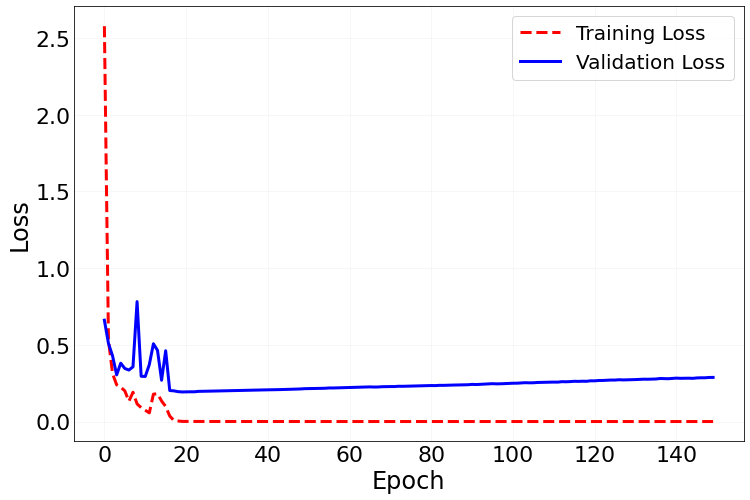

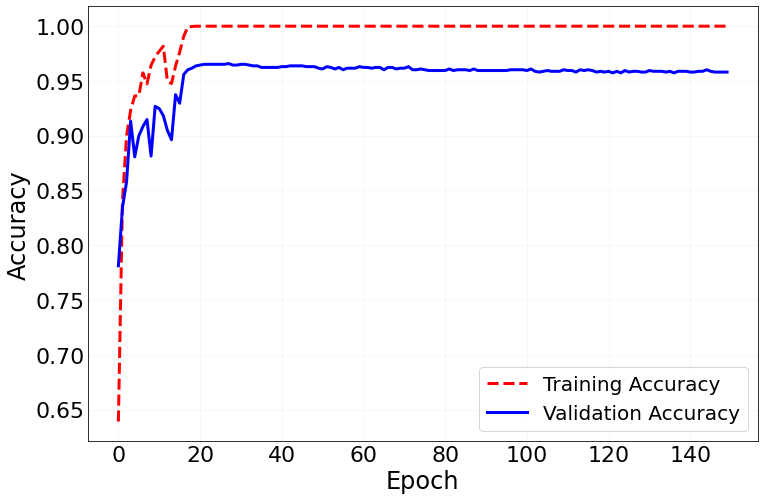

44/44 [==============================] - 0s 8ms/step
Normalized confusion matrix


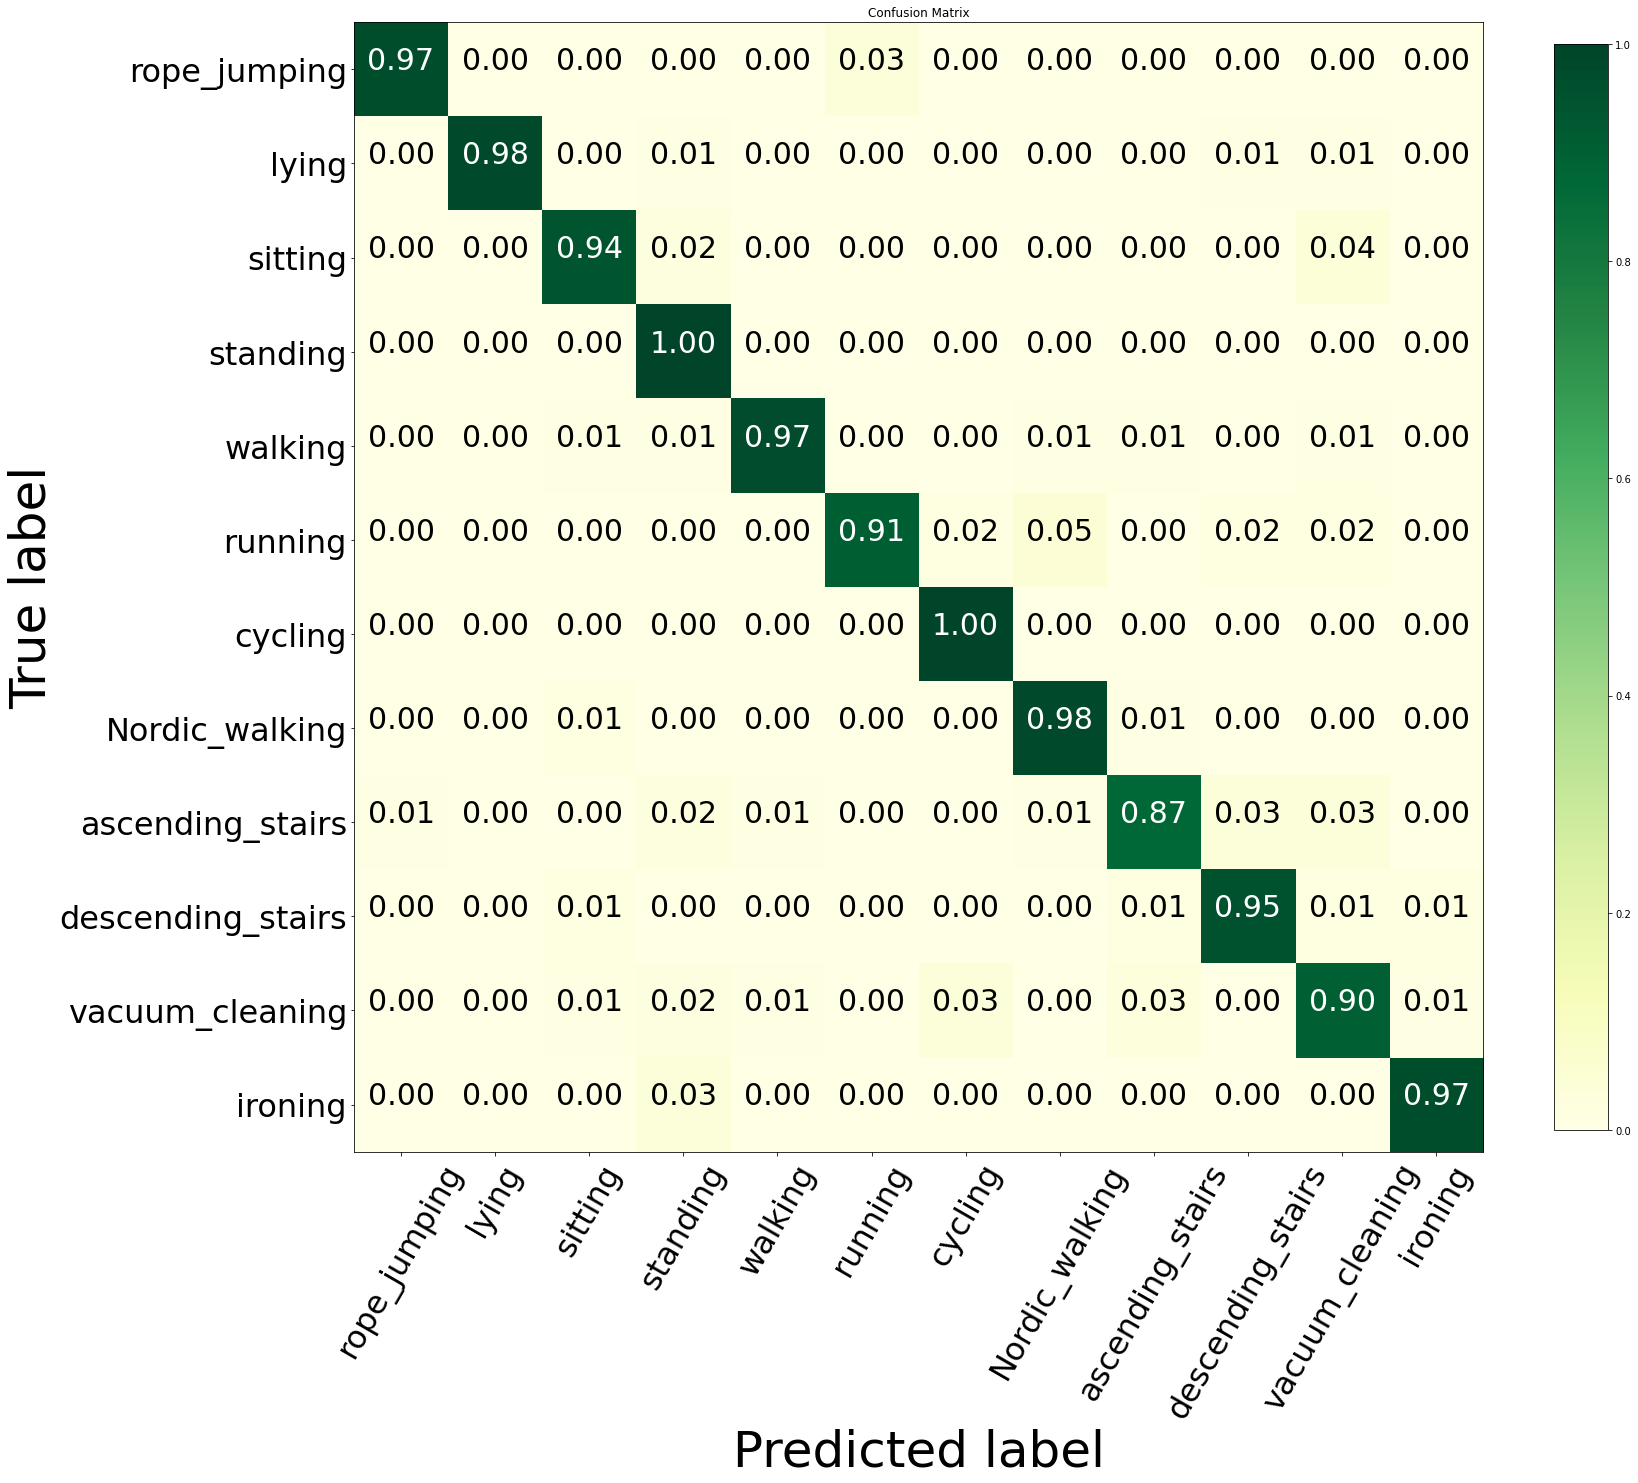

In [3]:
if __name__ == "__main__":
    model_name = "cnn" # can be cnn/dnn/rnn
    path = "./pamap_filtered.h5"
    pamap = models(path)
    print("read h5 file....")
    pamap.read_h5()

    if model_name == "cnn":
        pamap.cnn_model()
    elif model_name == "dnn":
        pamap.dnn_model()
    pamap.draw()
    pamap.con_matrix()